In [1]:
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np

import equinox as eqx
import diffrax
import optax

In [2]:
import os
os.chdir("..")
from policy.policy_training import DPCTrainer
from exciting_environments.pmsm.pmsm_env import PMSM
from policy.networks import MLP#,MLP2
import matplotlib.pyplot as plt

2025-02-06 21:43:34.635152: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[0])

## Model Learning

In [4]:
from utils.interactions import rollout_traj_env_policy
from models.model_training import ModelTrainer
from models.models import NeuralEulerODE

In [5]:
def featurize_node(obs):
    return obs[:4]

In [6]:
import json
with open('model_data/dmpe4.json') as json_data:
    d = json.load(json_data)
long_obs=jnp.array(d["observations"])
long_acts=jnp.array(d["actions"])
def step_eps(eps, omega_el, tau, tau_scale=1.0):
    eps += omega_el * tau * tau_scale
    eps %= 2 * jnp.pi
    boolean = eps > jnp.pi
    summation_mask = boolean * -2 * jnp.pi
    eps = eps + summation_mask
    return eps
eps=[0]
for i in range(long_obs.shape[0]):
    eps.append(step_eps(eps[-1],3*1500 / 60 * 2 * jnp.pi,1e-4))
cos_long_eps=jnp.cos(jnp.array(eps[:-1])[:,None])
sin_long_eps=jnp.sin(jnp.array(eps[:-1])[:,None])
long_obs=jnp.hstack([long_obs,cos_long_eps,sin_long_eps])

long_obs_train=long_obs[:-400]
long_acts_train=long_acts[:-400]
long_obs_val=long_obs[-400:]
long_acts_val=long_acts[-399:]

In [7]:
def data_gen_single(rng, sequence_len):
    rng, subkey = jax.random.split(rng)
    idx = jax.random.randint(subkey, shape=(1,),minval=0, maxval=(long_obs_train.shape[0]-sequence_len-1))

    slice = jnp.linspace(
            start=idx, stop=idx + sequence_len, num=sequence_len+1, dtype=int
        ).T
    act_slice = jnp.linspace(
            start=idx, stop=idx + sequence_len-1, num=sequence_len, dtype=int
        ).T
    
    obs=long_obs_train[slice][0]
    acts=long_acts_train[act_slice][0]
    return obs,acts,rng

In [8]:
from utils.interactions import rollout_traj_node

#@eqx.filter_jit
def validation(model_state,rng):
    feat_pred_obs = jax.vmap(rollout_traj_node,in_axes=(None,None,0,0,None))(model_state, featurize_node, long_obs_val[:-1, :], long_acts_val[:,None], 1e-4)
    feat_pred_obs = feat_pred_obs[:,1,:]
    feat_true_obs = jax.vmap(featurize_node, in_axes=(0))(long_obs_val[1:])
    terminate=False
    val_loss= jnp.mean((feat_pred_obs[:,:2] - feat_true_obs[:,:2]) ** 2) # validate only on i_dq and not cos(eps) and sin(eps)
    print(val_loss)
    return val_loss, terminate

In [9]:
jax_key = jax.random.PRNGKey(4)
node=NeuralEulerODE([6,128,128,128,128,4],key=jax_key)
optimizer_node = optax.adam(1e-4)
opt_state = optimizer_node.init(node)

In [ ]:
batch_size=100
mtrainer=ModelTrainer(
    train_steps=1_000_000,
    batch_size=batch_size,
    sequence_len=1,
    featurize=featurize_node,
    train_data_gen_sin=data_gen_single,
    validation= validation,
    model_optimizer=optimizer_node,
    tau= 1e-4
    )
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(batch_size,)))

  0%|          | 0/500000 [00:00<?, ?it/s]

/home/olivers/.conda/envs/venv_proj/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3042: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/home/olivers/.conda/envs/venv_proj/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3043: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  stop = asarray(stop, dtype=computation_dtype)
/home/olivers/.conda/envs/venv_proj/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py

0.120725065


  0%|          | 2126/500000 [00:04<13:35, 610.36it/s] 

0.013747774


  1%|          | 4109/500000 [00:08<17:36, 469.32it/s]

0.012867445


  1%|          | 6102/500000 [00:10<13:40, 601.99it/s]

0.011728679


  2%|▏         | 8092/500000 [00:13<13:28, 608.20it/s]

0.009867603


  2%|▏         | 10088/500000 [00:16<14:01, 582.00it/s]

0.0076329606


  2%|▏         | 12085/500000 [00:19<13:18, 610.69it/s]

0.0049653957


  3%|▎         | 14073/500000 [00:22<13:33, 597.51it/s]

0.0046663564


  3%|▎         | 16132/500000 [00:25<13:42, 588.42it/s]

0.0043391217


  4%|▎         | 18123/500000 [00:28<13:22, 600.81it/s]

0.003913274


  4%|▍         | 20125/500000 [00:31<13:16, 602.41it/s]

0.00335519


  4%|▍         | 22119/500000 [00:34<13:35, 586.06it/s]

0.0026476197


  5%|▍         | 24106/500000 [00:37<13:04, 606.24it/s]

0.0017887091


  5%|▌         | 26097/500000 [00:40<13:03, 605.18it/s]

0.0011651288


  6%|▌         | 28083/500000 [00:43<13:12, 595.66it/s]

0.0008487365


  6%|▌         | 30137/500000 [00:46<13:18, 588.40it/s]

0.00067283236


  6%|▋         | 32122/500000 [00:48<13:00, 599.26it/s]

0.0005716752


  7%|▋         | 34123/500000 [00:51<12:51, 603.56it/s]

0.00049467105


  7%|▋         | 36107/500000 [00:55<14:46, 523.01it/s]

0.00043504604


  8%|▊         | 38105/500000 [00:58<13:55, 552.79it/s]

0.00038210992


  8%|▊         | 40089/500000 [01:01<12:45, 600.94it/s]

0.00034354825


  8%|▊         | 42110/500000 [01:04<13:19, 572.46it/s]

0.0003290401


  9%|▉         | 44070/500000 [01:07<18:35, 408.79it/s]

0.00031711583


  9%|▉         | 46129/500000 [01:10<12:32, 603.09it/s]

0.00028768939


 10%|▉         | 48105/500000 [01:13<12:57, 581.16it/s]

0.0002916269


 10%|█         | 50091/500000 [01:16<12:31, 598.43it/s]

0.0002847268


 10%|█         | 52070/500000 [01:19<12:53, 578.94it/s]

0.00027836638


 11%|█         | 54128/500000 [01:22<14:03, 528.50it/s]

0.00027252574


 11%|█         | 56123/500000 [01:25<13:20, 554.74it/s]

0.00026043915


 12%|█▏        | 58116/500000 [01:28<13:58, 527.07it/s]

0.0002614483


 12%|█▏        | 60075/500000 [01:31<12:44, 575.24it/s]

0.000247625


 12%|█▏        | 62112/500000 [01:34<12:38, 577.05it/s]

0.00024701748


 13%|█▎        | 64096/500000 [01:37<12:18, 589.92it/s]

0.00024629515


 13%|█▎        | 66074/500000 [01:40<12:12, 592.07it/s]

0.00026035242


 14%|█▎        | 68110/500000 [01:43<12:32, 573.99it/s]

0.00026725404


 14%|█▍        | 70070/500000 [01:46<12:15, 584.81it/s]

0.00024774292


 14%|█▍        | 72123/500000 [01:49<11:58, 595.14it/s]

0.00024406877


 15%|█▍        | 74107/500000 [01:52<11:54, 596.10it/s]

0.000240643


 15%|█▌        | 76076/500000 [01:55<12:22, 571.03it/s]

0.0002363584


 16%|█▌        | 78096/500000 [01:58<11:42, 600.38it/s]

0.00024001428


 16%|█▌        | 80083/500000 [02:01<11:39, 600.58it/s]

0.00023360203


 16%|█▋        | 82070/500000 [02:04<13:04, 532.96it/s]

0.00023148932


 17%|█▋        | 84109/500000 [02:07<12:26, 557.42it/s]

0.0002321024


 17%|█▋        | 86108/500000 [02:11<13:53, 496.74it/s]

0.00022923882


 18%|█▊        | 88059/500000 [02:14<13:52, 494.77it/s]

0.00022661568


 18%|█▊        | 90128/500000 [02:17<11:24, 598.36it/s]

0.00022948232


 18%|█▊        | 92072/500000 [02:21<13:41, 496.85it/s]

0.00022904483


 19%|█▉        | 94066/500000 [02:24<13:40, 494.72it/s]

0.00022121398


 19%|█▉        | 96119/500000 [02:28<13:18, 505.49it/s]

0.00021404898


 20%|█▉        | 98087/500000 [02:31<11:13, 597.18it/s]

0.00022367884


 20%|██        | 100140/500000 [02:34<11:15, 591.98it/s]

0.00021186617


 20%|██        | 102084/500000 [02:37<11:21, 583.76it/s]

0.00021268288


 21%|██        | 104107/500000 [02:40<12:00, 549.39it/s]

0.0002107867


 21%|██        | 106105/500000 [02:43<11:57, 549.19it/s]

0.00021409839


 22%|██▏       | 108116/500000 [02:46<11:35, 563.52it/s]

0.00021284942


 22%|██▏       | 110074/500000 [02:49<11:16, 576.53it/s]

0.00021425099


 22%|██▏       | 112080/500000 [02:52<12:26, 519.52it/s]

0.00020389314


 23%|██▎       | 114120/500000 [02:55<13:11, 487.45it/s]

0.00020133173


 23%|██▎       | 116073/500000 [02:58<11:03, 579.03it/s]

0.00019753561


 24%|██▎       | 118095/500000 [03:01<11:08, 571.61it/s]

0.00020377281


 24%|██▍       | 120119/500000 [03:04<10:50, 583.90it/s]

0.0002167463


 24%|██▍       | 122134/500000 [03:07<10:52, 579.00it/s]

0.00022234934


 25%|██▍       | 124069/500000 [03:10<12:11, 514.15it/s]

0.00020192358


 25%|██▌       | 126091/500000 [03:13<10:52, 572.95it/s]

0.00021026726


 26%|██▌       | 128102/500000 [03:16<10:59, 563.50it/s]

0.00019900293


 26%|██▌       | 130113/500000 [03:19<10:54, 565.16it/s]

0.00020591814


 26%|██▋       | 132134/500000 [03:23<10:28, 584.95it/s]

0.00019378547


 27%|██▋       | 134081/500000 [03:25<10:33, 578.00it/s]

0.00019371834


 27%|██▋       | 136094/500000 [03:28<10:25, 581.42it/s]

0.00019320774


 28%|██▊       | 138101/500000 [03:32<12:27, 484.10it/s]

0.0002186258


 28%|██▊       | 140101/500000 [03:35<10:24, 576.62it/s]

0.00019394932


 28%|██▊       | 142082/500000 [03:38<10:45, 554.10it/s]

0.00020186958


 29%|██▉       | 144025/500000 [03:41<13:18, 446.06it/s]

0.00019462283


 29%|██▉       | 146139/500000 [03:45<10:07, 582.25it/s]

0.00019284188


 30%|██▉       | 148132/500000 [03:48<10:41, 548.69it/s]

0.0001920753


 30%|███       | 150115/500000 [03:51<10:26, 558.88it/s]

0.00019000735


 30%|███       | 152109/500000 [03:54<10:30, 551.92it/s]

0.00019474182


 31%|███       | 154111/500000 [03:57<10:20, 557.35it/s]

0.00018627479


 31%|███       | 156106/500000 [04:00<10:44, 533.42it/s]

0.0001946309


 32%|███▏      | 158108/500000 [04:03<10:05, 564.74it/s]

0.00019248252


 32%|███▏      | 160128/500000 [04:06<09:52, 573.18it/s]

0.00018824925


 32%|███▏      | 162111/500000 [04:09<09:47, 574.87it/s]

0.00018853642


 33%|███▎      | 164071/500000 [04:12<09:39, 580.08it/s]

0.00018057795


 33%|███▎      | 166101/500000 [04:15<09:37, 578.15it/s]

0.00018836408


 34%|███▎      | 168135/500000 [04:18<09:16, 595.96it/s]

0.00018300295


 34%|███▍      | 170085/500000 [04:21<08:41, 633.07it/s]

0.00018617017


 34%|███▍      | 172109/500000 [04:24<08:41, 629.30it/s]

0.00018958106


 35%|███▍      | 174134/500000 [04:27<08:34, 633.32it/s]

0.00017917242


 35%|███▌      | 176078/500000 [04:29<08:55, 605.38it/s]

0.0001800626


 36%|███▌      | 178099/500000 [04:32<08:45, 613.02it/s]

0.00018195121


 36%|███▌      | 180124/500000 [04:35<08:36, 619.37it/s]

0.00017985918


 36%|███▋      | 182139/500000 [04:38<08:48, 601.55it/s]

0.0001937521


 37%|███▋      | 184083/500000 [04:41<08:38, 609.03it/s]

0.00018593263


 37%|███▋      | 186106/500000 [04:43<08:28, 617.80it/s]

0.00018281913


 38%|███▊      | 188139/500000 [04:46<08:59, 578.37it/s]

0.00017997227


 38%|███▊      | 190119/500000 [04:49<09:04, 568.78it/s]

0.0001767209


 38%|███▊      | 192101/500000 [04:52<09:01, 568.53it/s]

0.00018051901


 39%|███▉      | 194108/500000 [04:55<09:15, 550.35it/s]

0.00017590029


 39%|███▉      | 196114/500000 [04:58<09:14, 548.03it/s]

0.00017295752


 40%|███▉      | 198110/500000 [05:02<09:19, 539.66it/s]

0.00019065419


 40%|████      | 200102/500000 [05:05<08:38, 578.68it/s]

0.00018977838


 40%|████      | 202129/500000 [05:07<08:36, 576.30it/s]

0.00017629465


 41%|████      | 204113/500000 [05:10<08:25, 585.17it/s]

0.00017062199


 41%|████      | 206033/500000 [05:13<08:43, 561.91it/s]

0.000175423


 42%|████▏     | 208086/500000 [05:17<07:52, 617.53it/s]

0.00017139061


 42%|████▏     | 210116/500000 [05:20<08:41, 556.08it/s]

0.00017951238


 42%|████▏     | 212102/500000 [05:23<08:35, 558.42it/s]

0.00016845916


 43%|████▎     | 214130/500000 [05:26<08:22, 569.13it/s]

0.00016823082


 43%|████▎     | 216091/500000 [05:29<08:11, 577.44it/s]

0.00018098149


 44%|████▎     | 218086/500000 [05:32<08:09, 575.85it/s]

0.00017348655


 44%|████▍     | 220113/500000 [05:35<08:00, 582.37it/s]

0.00016677962


 44%|████▍     | 222071/500000 [05:38<08:04, 574.16it/s]

0.00018438612


 45%|████▍     | 224086/500000 [05:41<08:10, 562.30it/s]

0.00018237968


 45%|████▌     | 226112/500000 [05:44<08:00, 570.49it/s]

0.00016877642


 46%|████▌     | 228070/500000 [05:47<07:53, 574.85it/s]

0.00016678586


 46%|████▌     | 230103/500000 [05:50<07:48, 576.33it/s]

0.00016747093


 46%|████▋     | 232132/500000 [05:53<07:36, 586.23it/s]

0.00016621203


 47%|████▋     | 234085/500000 [05:56<07:44, 572.11it/s]

0.00016141556


 47%|████▋     | 236091/500000 [05:59<07:50, 560.37it/s]

0.00016400125


 48%|████▊     | 238119/500000 [06:02<07:35, 575.31it/s]

0.00015871412


 48%|████▊     | 240078/500000 [06:05<07:30, 576.80it/s]

0.00016169871


 48%|████▊     | 242101/500000 [06:08<07:47, 551.22it/s]

0.00015970564


 49%|████▉     | 244127/500000 [06:11<07:28, 570.53it/s]

0.00015917208


 49%|████▉     | 246086/500000 [06:14<07:20, 575.83it/s]

0.00015576114


 50%|████▉     | 248110/500000 [06:17<07:21, 571.17it/s]

0.00016173313


 50%|█████     | 250107/500000 [06:20<07:36, 547.91it/s]

0.00015303996


 50%|█████     | 252103/500000 [06:23<07:36, 543.57it/s]

0.0001637279


 51%|█████     | 254110/500000 [06:26<07:26, 550.16it/s]

0.00015207862


 51%|█████     | 256101/500000 [06:29<07:58, 509.47it/s]

0.00015355814


 52%|█████▏    | 258131/500000 [06:32<07:16, 554.53it/s]

0.00014940675


 52%|█████▏    | 260068/500000 [06:36<07:16, 550.02it/s]

0.00014810075


 52%|█████▏    | 262066/500000 [06:39<07:21, 538.45it/s]

0.00014850455


 53%|█████▎    | 264124/500000 [06:42<07:11, 546.03it/s]

0.00014463929


 53%|█████▎    | 266099/500000 [06:45<07:21, 530.35it/s]

0.0001449782


 54%|█████▎    | 268088/500000 [06:48<07:14, 533.61it/s]

0.000147597


 54%|█████▍    | 270083/500000 [06:51<07:02, 544.19it/s]

0.00017253697


 54%|█████▍    | 272087/500000 [06:54<06:56, 546.79it/s]

0.00015434404


 55%|█████▍    | 274086/500000 [06:58<06:56, 542.20it/s]

0.0001490105


 55%|█████▌    | 276071/500000 [07:01<07:00, 532.74it/s]

0.0001466614


 56%|█████▌    | 278099/500000 [07:05<07:12, 513.40it/s]

0.0001499953


 56%|█████▌    | 280109/500000 [07:08<06:25, 570.79it/s]

0.00014460442


 56%|█████▋    | 282096/500000 [07:11<06:05, 596.68it/s]

0.00014598813


 57%|█████▋    | 284079/500000 [07:14<06:02, 596.45it/s]

0.00014497542


 57%|█████▋    | 286138/500000 [07:17<05:59, 595.67it/s]

0.00014010697


 58%|█████▊    | 288123/500000 [07:20<05:54, 597.33it/s]

0.0001415934


 58%|█████▊    | 290107/500000 [07:23<05:55, 590.66it/s]

0.00014221297


 58%|█████▊    | 292092/500000 [07:26<05:58, 580.29it/s]

0.00013829436


 59%|█████▉    | 294077/500000 [07:29<05:52, 584.69it/s]

0.00014393235


 59%|█████▉    | 296132/500000 [07:32<05:53, 577.24it/s]

0.00014444011


 60%|█████▉    | 298107/500000 [07:35<06:14, 538.93it/s]

0.00014665678


 60%|██████    | 300089/500000 [07:38<06:54, 482.84it/s]

0.00015448473


 60%|██████    | 302082/500000 [07:42<06:49, 482.91it/s]

0.00013735438


 61%|██████    | 304115/500000 [07:45<05:33, 587.30it/s]

0.00013973842


 61%|██████    | 306099/500000 [07:48<05:35, 578.43it/s]

0.00013662285


 62%|██████▏   | 308091/500000 [07:51<05:20, 599.31it/s]

0.00013533443


 62%|██████▏   | 310081/500000 [07:54<05:19, 593.72it/s]

0.00013677611


 62%|██████▏   | 312120/500000 [07:57<05:33, 562.80it/s]

0.00013820367


 63%|██████▎   | 314112/500000 [08:00<05:10, 598.65it/s]

0.00014287615


 63%|██████▎   | 316101/500000 [08:02<05:08, 596.82it/s]

0.00014233017


 64%|██████▎   | 318080/500000 [08:05<05:03, 598.96it/s]

0.00014421705


 64%|██████▍   | 320142/500000 [08:08<05:01, 596.42it/s]

0.00013543139


 64%|██████▍   | 322131/500000 [08:11<05:00, 591.51it/s]

0.00013654004


 65%|██████▍   | 324116/500000 [08:14<05:04, 578.55it/s]

0.0001347639


 65%|██████▌   | 326106/500000 [08:17<04:59, 580.16it/s]

0.00013462278


 66%|██████▌   | 328107/500000 [08:20<04:57, 578.23it/s]

0.00014259259


 66%|██████▌   | 330087/500000 [08:23<04:57, 571.39it/s]

0.00013647968


 66%|██████▋   | 332111/500000 [08:26<04:47, 583.86it/s]

0.00013352802


 67%|██████▋   | 334078/500000 [08:29<04:43, 586.18it/s]

0.0001322651


 67%|██████▋   | 336122/500000 [08:32<04:38, 588.98it/s]

0.00013385437


 68%|██████▊   | 338085/500000 [08:35<05:11, 518.99it/s]

0.0001372634


 68%|██████▊   | 340075/500000 [08:38<04:35, 581.18it/s]

0.00013900918


 68%|██████▊   | 342102/500000 [08:41<04:31, 582.23it/s]

0.00014071516


 69%|██████▉   | 344084/500000 [08:44<05:16, 492.61it/s]

0.00013610425


 69%|██████▉   | 346083/500000 [08:48<04:31, 567.33it/s]

0.00013189216


 70%|██████▉   | 348130/500000 [08:51<04:17, 590.54it/s]

0.00013747982


 70%|███████   | 350105/500000 [08:53<04:12, 593.86it/s]

0.0001298034


 70%|███████   | 352089/500000 [08:57<04:10, 589.64it/s]

0.0001364752


 71%|███████   | 354080/500000 [08:59<04:12, 578.62it/s]

0.00012911795


 71%|███████   | 356115/500000 [09:02<03:59, 600.92it/s]

0.0001363373


 72%|███████▏  | 358104/500000 [09:05<03:58, 593.76it/s]

0.00013373495


 72%|███████▏  | 360131/500000 [09:09<03:52, 602.68it/s]

0.00012807541


 72%|███████▏  | 362116/500000 [09:12<03:50, 599.05it/s]

0.00012683995


 73%|███████▎  | 364096/500000 [09:15<03:46, 599.34it/s]

0.00013410067


 73%|███████▎  | 366061/500000 [09:18<04:35, 486.59it/s]

0.00012737987


 74%|███████▎  | 368101/500000 [09:22<04:30, 487.47it/s]

0.00012976254


 74%|███████▍  | 370119/500000 [09:25<03:39, 591.05it/s]

0.00012915581


 74%|███████▍  | 372099/500000 [09:28<03:45, 566.91it/s]

0.00012750486


 75%|███████▍  | 374119/500000 [09:32<04:06, 510.88it/s]

0.00012819149


 75%|███████▌  | 376076/500000 [09:35<04:07, 501.18it/s]

0.00012674634


 76%|███████▌  | 378089/500000 [09:39<04:03, 499.92it/s]

0.00013090794


 76%|███████▌  | 380116/500000 [09:42<04:11, 476.47it/s]

0.00012611304


 76%|███████▋  | 382081/500000 [09:46<03:51, 509.34it/s]

0.0001242381


 77%|███████▋  | 384106/500000 [09:49<03:22, 571.65it/s]

0.00012952079


 77%|███████▋  | 386081/500000 [09:52<03:18, 573.94it/s]

0.00012853113


 78%|███████▊  | 388107/500000 [09:55<03:12, 580.63it/s]

0.00012452425


 78%|███████▊  | 390133/500000 [09:58<03:09, 579.72it/s]

0.00013000472


 78%|███████▊  | 392090/500000 [10:01<03:04, 583.87it/s]

0.00012905656


 79%|███████▉  | 394119/500000 [10:04<03:01, 584.95it/s]

0.000127304


 79%|███████▉  | 396075/500000 [10:07<02:57, 584.69it/s]

0.0001239218


 80%|███████▉  | 398100/500000 [10:10<02:55, 581.64it/s]

0.00011982021


 80%|████████  | 400128/500000 [10:13<02:50, 585.49it/s]

0.00012613142


 80%|████████  | 402088/500000 [10:16<02:46, 588.10it/s]

0.00012669318


 81%|████████  | 404107/500000 [10:19<02:48, 570.50it/s]

0.00012362534


 81%|████████  | 406087/500000 [10:22<02:49, 554.47it/s]

0.00012694667


 82%|████████▏ | 408069/500000 [10:25<02:46, 551.28it/s]

0.00014045458


 82%|████████▏ | 410068/500000 [10:28<02:41, 557.91it/s]

0.00012062247


 82%|████████▏ | 412075/500000 [10:31<02:37, 556.52it/s]

0.00012119694


 83%|████████▎ | 414118/500000 [10:34<02:34, 555.46it/s]

0.0001224669


 83%|████████▎ | 416098/500000 [10:37<02:31, 552.53it/s]

0.00011996484


 84%|████████▎ | 418087/500000 [10:40<02:28, 552.31it/s]

0.000119295


 84%|████████▍ | 420068/500000 [10:44<02:24, 553.13it/s]

0.00013360148


 84%|████████▍ | 422126/500000 [10:47<02:21, 551.98it/s]

0.0001225542


 85%|████████▍ | 424111/500000 [10:50<02:18, 548.00it/s]

0.00013034738


 85%|████████▌ | 426093/500000 [10:53<02:13, 553.05it/s]

0.000120595105


 86%|████████▌ | 428077/500000 [10:56<02:11, 548.31it/s]

0.000121664794


 86%|████████▌ | 430123/500000 [10:59<02:10, 537.48it/s]

0.000118829616


 86%|████████▋ | 432083/500000 [11:02<01:56, 583.99it/s]

0.00012318882


 87%|████████▋ | 434137/500000 [11:05<01:52, 585.32it/s]

0.000121341895


 87%|████████▋ | 436115/500000 [11:08<01:49, 582.54it/s]

0.00012519443


 88%|████████▊ | 438102/500000 [11:11<01:45, 585.28it/s]

0.00011875572


 88%|████████▊ | 440086/500000 [11:14<01:42, 584.87it/s]

0.00012543444


 88%|████████▊ | 442140/500000 [11:17<01:39, 583.07it/s]

0.00011629852


 89%|████████▉ | 444124/500000 [11:20<01:34, 593.46it/s]

0.00012017321


 89%|████████▉ | 446108/500000 [11:23<01:31, 590.54it/s]

0.0001248109


 90%|████████▉ | 448092/500000 [11:26<01:28, 588.49it/s]

0.00012884091


 90%|█████████ | 450077/500000 [11:29<01:24, 593.23it/s]

0.00011984201


 90%|█████████ | 452135/500000 [11:32<01:20, 593.14it/s]

0.00012293829


 91%|█████████ | 454115/500000 [11:36<01:17, 594.98it/s]

0.00011658984


 91%|█████████ | 456101/500000 [11:39<01:13, 596.84it/s]

0.00011822973


 92%|█████████▏| 458081/500000 [11:41<01:10, 596.65it/s]

0.00012192937


 92%|█████████▏| 460138/500000 [11:45<01:06, 602.88it/s]

0.00011874775


 92%|█████████▏| 462125/500000 [11:47<01:03, 597.00it/s]

0.00012632315


 93%|█████████▎| 464112/500000 [11:50<00:59, 599.29it/s]

0.00012414325


 93%|█████████▎| 466101/500000 [11:53<00:56, 599.28it/s]

0.00011728445


 94%|█████████▎| 468087/500000 [11:56<00:53, 595.80it/s]

0.000120785655


 94%|█████████▍| 470074/500000 [11:59<00:50, 595.76it/s]

0.000115496994


 94%|█████████▍| 472135/500000 [12:02<00:46, 596.45it/s]

0.00011387795


 95%|█████████▍| 474122/500000 [12:05<00:43, 589.62it/s]

0.00011684445


 95%|█████████▌| 476109/500000 [12:08<00:41, 575.40it/s]

0.00012608817


 96%|█████████▌| 478095/500000 [12:11<00:37, 588.17it/s]

0.00011990283


 96%|█████████▌| 480082/500000 [12:14<00:33, 587.99it/s]

0.000116450356


 96%|█████████▋| 482070/500000 [12:17<00:32, 543.41it/s]

0.00011486352


 97%|█████████▋| 484120/500000 [12:20<00:27, 587.30it/s]

0.000116010364


 97%|█████████▋| 486108/500000 [12:23<00:23, 588.93it/s]

0.00011604181


 98%|█████████▊| 488096/500000 [12:25<00:20, 591.09it/s]

0.00011469791


 98%|█████████▊| 490082/500000 [12:28<00:16, 588.85it/s]

0.000113499606


 98%|█████████▊| 492100/500000 [12:32<00:15, 505.91it/s]

0.000113610244


 99%|█████████▉| 494123/500000 [12:35<00:10, 581.66it/s]

0.00011157892


 99%|█████████▉| 496073/500000 [12:38<00:06, 577.68it/s]

0.00011200737


100%|█████████▉| 498112/500000 [12:41<00:03, 623.67it/s]

0.00011688141


100%|██████████| 500000/500000 [12:43<00:00, 654.64it/s]


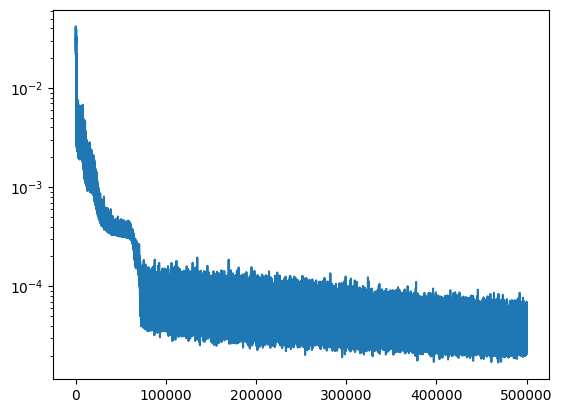

In [11]:
fin_node50,fin_opt_state,fin_keys,losses, val_losses=mtrainer.fit(node,opt_state,keys,validate_every=2000)
plt.plot(losses)
plt.yscale('log')


In [12]:
#eqx.tree_serialise_leaves("trained_models/DMPE_Model_100k_50len_100b_step0_0001.eqx", fin_node50)

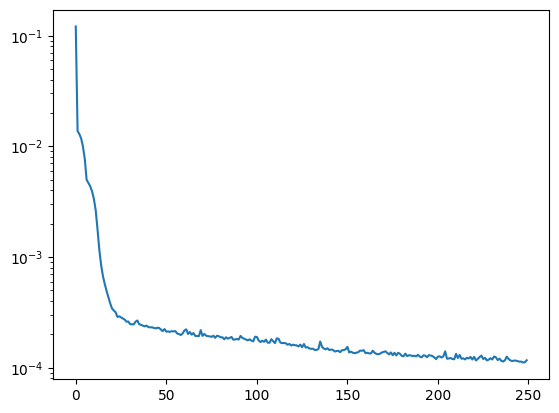

In [15]:
plt.plot(val_losses)
plt.yscale('log')

In [16]:
val_losses

[Array(0.12072507, dtype=float32),
 Array(0.01374777, dtype=float32),
 Array(0.01286745, dtype=float32),
 Array(0.01172868, dtype=float32),
 Array(0.0098676, dtype=float32),
 Array(0.00763296, dtype=float32),
 Array(0.0049654, dtype=float32),
 Array(0.00466636, dtype=float32),
 Array(0.00433912, dtype=float32),
 Array(0.00391327, dtype=float32),
 Array(0.00335519, dtype=float32),
 Array(0.00264762, dtype=float32),
 Array(0.00178871, dtype=float32),
 Array(0.00116513, dtype=float32),
 Array(0.00084874, dtype=float32),
 Array(0.00067283, dtype=float32),
 Array(0.00057168, dtype=float32),
 Array(0.00049467, dtype=float32),
 Array(0.00043505, dtype=float32),
 Array(0.00038211, dtype=float32),
 Array(0.00034355, dtype=float32),
 Array(0.00032904, dtype=float32),
 Array(0.00031712, dtype=float32),
 Array(0.00028769, dtype=float32),
 Array(0.00029163, dtype=float32),
 Array(0.00028473, dtype=float32),
 Array(0.00027837, dtype=float32),
 Array(0.00027253, dtype=float32),
 Array(0.00026044, dty